In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from scipy.stats import randint, uniform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, log_loss
from tqdm.auto import tqdm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.preprocessing import label_binarize

from collections import Counter

C:\Users\Azevedo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read cleaned data from csv
df = pd.read_csv('input/movie_data_tmbd_cleaned.csv', sep='|')

In [3]:
# Print info about the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17426 entries, 0 to 17425
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  17426 non-null  bool   
 1   backdrop_path          16267 non-null  object 
 2   belongs_to_collection  3369 non-null   object 
 3   budget                 17426 non-null  int64  
 4   genres                 17426 non-null  object 
 5   homepage               4959 non-null   object 
 6   id                     17426 non-null  float64
 7   imdb_id                17420 non-null  object 
 8   original_language      17426 non-null  object 
 9   original_title         17426 non-null  object 
 10  overview               17365 non-null  object 
 11  popularity             17426 non-null  float64
 12  poster_path            17426 non-null  object 
 13  production_companies   17426 non-null  object 
 14  production_countries   17426 non-null  object 
 15  re

# Scoring prediction

In [4]:
# Take only the columns we need
df = df[['original_title', 'original_language', 'release_date', 'popularity', 'vote_count', 'genres', 'overview', 'budget', 'revenue', 'spoken_languages', 'runtime', 'vote_average']]
print(df.head())

         original_title original_language release_date  popularity  \
0  Lonely Are the Brave                en   1962-05-24       8.262   
1  Vérités et Mensonges                fr   1975-03-12       7.830   
2    Il colosso di Rodi                it   1961-06-15       9.668   
3                Victim                en   1961-08-01       5.896   
4     Sergeant Rutledge                en   1960-05-18       6.003   

   vote_count                                             genres  \
0        70.0  [{'id': 18, 'name': 'Drama'}, {'id': 37, 'name...   
1       178.0                [{'id': 99, 'name': 'Documentary'}]   
2        94.0                    [{'id': 36, 'name': 'History'}]   
3        57.0                      [{'id': 18, 'name': 'Drama'}]   
4        59.0                    [{'id': 37, 'name': 'Western'}]   

                                            overview  budget  revenue  \
0  A fiercely independent cowboy arranges to have...       0        0   
1  Documents the lives o

Axes(0.125,0.11;0.775x0.77)


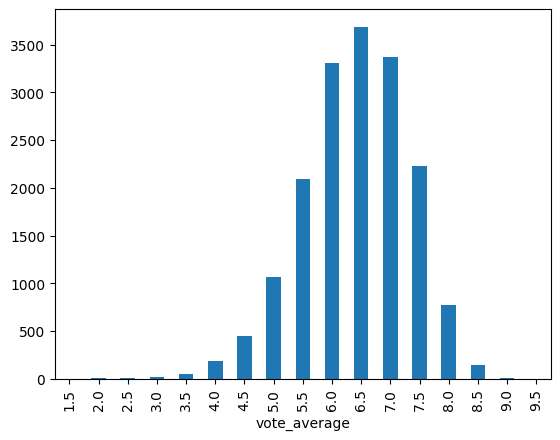

In [5]:
# Map 'vote_average' to nearest 0.5
df['vote_average'] = ((df['vote_average'] * 2).round() / 2)
print(df['vote_average'].value_counts().sort_index().plot(kind='bar'))

In [6]:
#Group vote_average into categories:
# 0.0-5.0 -> bad
# 5.5-6.0 -> mediocre
# 6.5-7.0 -> good
# 7.5-9.9 -> great

# Define the bins and labels
bins = [0.0, 5.0, 6.0, 7.0, 9.9]
labels = ['bad', 'mediocre', 'good', 'great']

# Group vote_average into categories
df['category'] = pd.cut(df['vote_average'], bins=bins, labels=labels, right=True)

# Display the DataFrame
print(df['category'].value_counts())

category
good        7064
mediocre    5407
great       3161
bad         1794
Name: count, dtype: int64


In [7]:
print(df.info())
print("Duplicates: " + str(df.duplicated().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17426 entries, 0 to 17425
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   original_title     17426 non-null  object  
 1   original_language  17426 non-null  object  
 2   release_date       17425 non-null  object  
 3   popularity         17426 non-null  float64 
 4   vote_count         17426 non-null  float64 
 5   genres             17426 non-null  object  
 6   overview           17365 non-null  object  
 7   budget             17426 non-null  int64   
 8   revenue            17426 non-null  int64   
 9   spoken_languages   17426 non-null  object  
 10  runtime            17426 non-null  float64 
 11  vote_average       17426 non-null  float64 
 12  category           17426 non-null  category
dtypes: category(1), float64(4), int64(2), object(6)
memory usage: 1.6+ MB
None
Duplicates: 0


In [8]:
# X-> only Attribute columns
# Y-> only Target column
X = df.drop(columns=['vote_average', 'category'])
Y = df['category']


In [9]:
# 20% test and 80% train (test_size=0.2)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Training set size: ", len(X_train))
print("Test set size: ", len(X_test))

Training set size:  13940
Test set size:  3486


# Transparent Models

## Decision Tree

Can use both numerical and non-numerical data.

### C4.5 Algorithm

Functions needed to help calculate the Information Gain Ratio to be used with the tree. Attention for being a Multi-class Classification problem (4 possible values).


In [10]:
def entropy(target_col):
    elements, counts = np.unique(target_col, return_counts=True)
    #Portion of 'bad' = counts['bad']/np.sum(counts)
    entropy_value = np.sum([(-counts[i]/np.sum(counts)) * np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy_value

In [11]:
# 'category' has 4 possible values, so Entropy can range from 0 (perfectly pure, all values in one class) to 2 (all classes represented equally in the same number each)
e = entropy(df['category'])
elements, counts = np.unique(df['category'], return_counts=True)
print(e)
print(elements)
print(counts)

1.836347865114912
['bad' 'good' 'great' 'mediocre']
[1794 7064 3161 5407]


In [12]:
#Information Gain -> the expected reduction in entropy (more proximate to 0 = more pure = reached decision) caused by partitioning the dataset according to split_attribute_name
#                 -> the amount of information gained by spliting the data using split_attribute_name
#                 -> higher values are better
def info_gain(data, split_attribute_name, target_name='category'):
    total_entropy = entropy(data[target_name]) #entropy(df['category'])
    
    # All possible values for the splitting attribute
    values, counts = np.unique(data[split_attribute_name], return_counts=True)
    
    weighted_entropy = np.sum([(counts[i]/np.sum(counts)) * entropy(data.where(data[split_attribute_name] == values[i]).dropna()[target_name]) for i in range(len(values))])
    
    information_gain = total_entropy - weighted_entropy
    return information_gain

In [13]:
igainex1 = info_gain(df, 'budget')
print(igainex1)

igainex2 = info_gain(df, 'popularity')
print(igainex2)

0.13617696112067446
1.3565388151775262


In [14]:
#Information Gain Ratio  ->  ratio of information gain to the intrinsic information
#                        -> reduce a bias towards multi-valued attributes by taking the number and size of branches into account when choosing an attribute, biases the decision tree against considering attributes with a large number of distinct values (ex: ID would lead to maximum purity)
#                        -> higher values are better
def info_gain_ratio(data, split_attribute_name, target_name='category'):
    information_gain = info_gain(data, split_attribute_name, target_name)
    
    # Split information = Intrinsic value  -> is a positive number that describes the potential worth of splitting a branch from a node. 
    # This in turn is the intrinsic value that the spliting attribute possesses and will be used to remove the bias in the information gain ratio calculation. (src: Wikipedia)
    values, counts = np.unique(data[split_attribute_name], return_counts=True)
    split_information = np.sum([(-counts[i]/np.sum(counts)) * np.log2(counts[i]/np.sum(counts)) for i in range(len(values))])
    
    # Avoidinge division by zero
    if split_information == 0:
        return 0
    
    # Gain ratio is the information gain divided by intrinsic value
    return information_gain / split_information

In [15]:
igrex1 = info_gain_ratio(df, 'budget')
print(igrex1)

igrex1 = info_gain_ratio(df, 'popularity')
print(igrex1)


0.03125318144722874
0.10169611568231932


In [16]:
# C4.5 Recursive Algorithm to build the Decision Tree
def c45_tree(data, original_data, features, target_name='category', parent_node_class=None):
    
    # Base case 1: If all target values are the same, return that class
    if len(np.unique(data[target_name])) <= 1:
        return np.unique(data[target_name])[0]
    
    # Base case 2: If dataset is empty, return the class of the parent node
    elif len(data) == 0:
        return parent_node_class
    
    # Base case 3: If no more features to split on, return the majority class of the current node
    elif len(features) == 0:
        return parent_node_class
    
    # Base case 4: If the data is pure (contains only one class)
    else:
        parent_node_class = np.unique(data[target_name])[np.argmax(np.unique(data[target_name], return_counts=True)[1])]
        
        # Select the feature with the highest gain ratio
        gain_ratios = [info_gain_ratio(data, feature, target_name) for feature in features]
        best_feature_index = np.argmax(gain_ratios)
        best_feature = features[best_feature_index]
        
        # Create the tree structure (dictionary)
        tree = {best_feature: {}}
        
        # Remove the best feature from the feature list
        features = [i for i in features if i != best_feature]
        
        # For each value of the best feature, split the data and recursively build the tree
        for value in np.unique(data[best_feature]):
            sub_data = data.where(data[best_feature] == value).dropna()
        
            subtree = c45_tree(sub_data, original_data, features, target_name, parent_node_class)
            tree[best_feature][value] = subtree
        
        return tree


### CARD Algorithm